# Global Station Papa Apex Profiler Mooring Dissolved Oxygen Data Quality Report

**Evaluation Date**: August 3, 2018

**Evaluator**: Frankie Pavia, Lamont-Doherty Earth Observatory

## 1. Selected instruments included in this report
In this report, we will evaluate the Oxygen Sensors from the Global Station Papa Apex Profiler Mooring (GP02HYPM), focusing on the second half of 2015, since there is overlapping data coverage during that period. The profiler on the upper mooring covers 310-2093m depth, and the profiler on the lower mooring covers 2100-4038m depth 

Instrument | Reference Designator | Method | Stream | Depth Range
 -- | -- | -- | --
Dissolved Oxygen | [GP02HYPM-WFP02-03-DOSTAL000](http://ooi.visualocean.net/instruments/view/GP02HYPM-WFP02-03-DOSTAL000) | recovered_wfp | dosta_ln_wfp_instrument_recovered | 310-2093m
Dissolved Oxygen | [GP02HYPM-WFP03-03-DOSTAL000](http://ooi.visualocean.net/instruments/view/GP02HYPM-WFP03-03-DOSTAL000) | recovered_wfp | dosta_ln_wfp_instrument_recovered | 2100-4038m


## Location of Global Station Papa

<img src="OOI-ALL-Arrays-8.5x11_CS5_GP.jpg" alt="Drawing" width="500"/>

## Schematic of Apex Profiler Mooring

<img src="GP02HYPM_Papa_Apex_Profiler_Mooring.jpg" alt="Drawing" width="250"/>

In [1]:
#Import packages needed for environment, as well as username and token for requesting data from OOI 
USERNAME = ''
TOKEN =  ''
# First, we need to add some more Python libraries
import requests
import datetime
import time
import xarray as xr
import requests
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import cmocean
#import gsw

/opt/conda/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
# Specify some functions to convert timestamps
ntp_epoch = datetime.datetime(1900, 1, 1)
unix_epoch = datetime.datetime(1970, 1, 1)
ntp_delta = (unix_epoch - ntp_epoch).total_seconds()

def ntp_seconds_to_datetime(ntp_seconds):
    return datetime.datetime.utcfromtimestamp(ntp_seconds - ntp_delta).replace(microsecond=0)
  
def convert_time(ms):
  if ms != None:
    return datetime.datetime.utcfromtimestamp(ms/1000)
  else:
    return None

## 2. Metadata Review

Here we review the metadata associated with the datasets for both mooring. We will load in the two datasets separately via the OOI API. 

In [3]:
# Data request generation code
# API base url
SENSOR_BASE_URL = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/'
VOCAB_BASE_URL = 'https://ooinet.oceanobservatories.org/api/m2m/12586/vocab/inv'
ASSET_BASE_URL = 'https://ooinet.oceanobservatories.org/api/m2m/12587'
# Get data from Profilers - they share everything except node numbers
site = 'GP02HYPM'
#This is the node for the shallow profiler
node = 'WFP02'
#This is the node for the deep profiler
node2 = 'WFP03'
instrument = '03-DOSTAL000'
method = 'recovered_wfp'
stream = 'dosta_ln_wfp_instrument_recovered'
#Generate data request for the shallow mooring
data_request_url ='/'.join((SENSOR_BASE_URL,site,node,instrument,method,stream))
#Generate data request for the deep mooring
data_request_url2 = '/'.join((SENSOR_BASE_URL,site,node2,instrument,method,stream))
#Generate vocabulary request for the shallow mooring
vocab_request_url ='/'.join((VOCAB_BASE_URL,site,node,instrument))
#Generate vocabulary request for the deep mooring
vocab_request_url2 = '/'.join((VOCAB_BASE_URL,site,node2,instrument))
# All of the following are optional
params = {
  'format':'application/netcdf',
  'include_provenance':'true',
  'include_annotations':'true'
}
#Print the URL for the shallow mooring data request
print(data_request_url)
#Print the URL for the deep mooring data request
print(data_request_url2)
#Print the URL for the shallow mooring vocab request
print(vocab_request_url)
#Print the URL for the deep mooring vocab request
print(vocab_request_url2)

https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv//GP02HYPM/WFP02/03-DOSTAL000/recovered_wfp/dosta_ln_wfp_instrument_recovered
https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv//GP02HYPM/WFP03/03-DOSTAL000/recovered_wfp/dosta_ln_wfp_instrument_recovered
https://ooinet.oceanobservatories.org/api/m2m/12586/vocab/inv/GP02HYPM/WFP02/03-DOSTAL000
https://ooinet.oceanobservatories.org/api/m2m/12586/vocab/inv/GP02HYPM/WFP03/03-DOSTAL000


### Inspect vocabulary metadata from both profilers

In [4]:
#This requests vocabulary from the 310-2100 Profiler
r = requests.get(vocab_request_url, auth=(USERNAME, TOKEN))
data = r.json()
data

[{'@class': '.VocabRecord',
  'model': 'Optode 4330',
  'manufacturer': 'Aanderaa',
  'vocabId': 1064,
  'refdes': 'GP02HYPM-WFP02-03-DOSTAL000',
  'instrument': 'Dissolved Oxygen',
  'tocL1': 'Global Station Papa',
  'tocL2': 'Apex Profiler Mooring',
  'tocL3': 'Wire-Following Profiler Upper',
  'mindepth': 310.0,
  'maxdepth': 2093.0}]

Looks Correct!

In [5]:
#This requests vocabulary from the 310-2100 Profiler - commented out since request has already been generated
r2 = requests.get(vocab_request_url2, auth=(USERNAME, TOKEN))
data2 = r2.json()
data2

[{'@class': '.VocabRecord',
  'model': 'Optode 4330',
  'manufacturer': 'Aanderaa',
  'vocabId': 1070,
  'refdes': 'GP02HYPM-WFP03-03-DOSTAL000',
  'instrument': 'Dissolved Oxygen',
  'tocL1': 'Global Station Papa',
  'tocL2': 'Apex Profiler Mooring',
  'tocL3': 'Wire-Following Profiler Lower',
  'mindepth': 2100.0,
  'maxdepth': 4038.0}]

This also looks correct!

### Inspect Deployment Information

In [6]:
asset_request_url = ASSET_BASE_URL + '/events/deployment/query'
#
params1 = {
  'refdes':site+'-'+node+'-'+instrument,   
}
params2 = {
  'refdes':site+'-'+node2+'-'+instrument,   
}
# Grab the information from the server
r = requests.get(asset_request_url, params=params1, auth=(USERNAME, TOKEN))
r2 = requests.get(asset_request_url, params=params2, auth=(USERNAME, TOKEN))
data = r.json()
data2 = r2.json()

In [7]:
#Make table of data from deployment 1
df = pd.DataFrame() # Setup empty array
for d in data:
  df = df.append({
      'deployment': d['deploymentNumber'],
      'start': convert_time(d['eventStartTime']),
      'stop': convert_time(d['eventStopTime']),
      'latitude': d['location']['latitude'],
      'longitude': d['location']['longitude'],
      'sensor': d['sensor']['uid'],
      'asset_id': d['sensor']['assetId'],
    }, ignore_index=True)
df

,asset_id,deployment,latitude,longitude,sensor,start,stop
0,1333.0,1.0,50.07067,-144.79800,CGINS-DOSTAL-01086,2013-07-26 08:11:00,2014-06-14 00:00:00
1,1333.0,2.0,50.07833,-144.80533,CGINS-DOSTAL-01086,2014-06-16 02:15:00,2015-06-02 00:00:00
2,1062.0,3.0,50.07983,-144.80300,CGINS-DOSTAL-01105,2015-06-04 23:38:00,2016-07-01 18:56:00
3,2698.0,4.0,50.07960,-144.80572,CGINS-DOSTAL-01480,2016-07-03 02:05:00,2017-07-16 15:20:00
4,2696.0,5.0,50.11560,-144.91760,CGINS-DOSTAL-01478,2017-07-15 21:25:00,None


In [8]:
#Make table of data from deployment 1
df2 = pd.DataFrame() # Setup empty array
for d in data2:
  df2 = df2.append({
      'deployment': d['deploymentNumber'],
      'start': convert_time(d['eventStartTime']),
      'stop': convert_time(d['eventStopTime']),
      'latitude': d['location']['latitude'],
      'longitude': d['location']['longitude'],
      'sensor': d['sensor']['uid'],
      'asset_id': d['sensor']['assetId'],
    }, ignore_index=True)
df2

,asset_id,deployment,latitude,longitude,sensor,start,stop
0,1063.0,1.0,50.07067,-144.79800,CGINS-DOSTAL-01106,2013-07-26 08:11:00,2014-06-14 00:00:00
1,2698.0,2.0,50.07833,-144.80533,CGINS-DOSTAL-01480,2014-06-16 02:15:00,2015-06-02 00:00:00
2,2696.0,3.0,50.07983,-144.80300,CGINS-DOSTAL-01478,2015-06-04 23:38:00,2016-07-01 18:56:00
3,1333.0,4.0,50.07960,-144.80572,CGINS-DOSTAL-01086,2016-07-03 02:05:00,2017-07-16 15:20:00
4,1062.0,5.0,50.11560,-144.91760,CGINS-DOSTAL-01105,2017-07-15 21:25:00,None


## Inspect calibration information for the two datasets

We will only inspect calibration info from the third deployment

In [9]:
calib_request_url = ASSET_BASE_URL + '/asset/cal'
params = {
  'beginDT':'2015-06-04T00:00:00.000Z',
  'endDT':'2016-07-01T00:00:00.000Z',
  'refdes':site+'-'+node+'-'+'instrument',
}
params1 = {
  'beginDT':'2015-06-04T00:00:00.000Z',
  'endDT':'2016-07-01T00:00:00.000Z',
  'refdes':site+'-'+node2+'-'+'instrument',
}


In [10]:
# Grab the information from the server
r = requests.get(calib_request_url, params=params, auth=(USERNAME, TOKEN))
data = r.json()
r2 = requests.get(calib_request_url, params=params2, auth=(USERNAME, TOKEN))
data2 = r2.json()
data

[]

There doesn't appear to be any calibration data available for either of these sensors.

## Annotations

Pull any annotations for these datasets

In [11]:
#Pull annotations for the first 
ANNO_API = 'https://ooinet.oceanobservatories.org/api/m2m/12580/anno/find'
params = {
  'beginDT':int(datetime.date(2010,6,1).strftime('%s'))*1000,
  'endDT':int(datetime.date(2018,7,1).strftime('%s'))*1000,
  'refdes':site+'-'+node+'-'+instrument,
}
params1 = {
 'beginDT':int(datetime.date(2010,6,1).strftime('%s'))*1000,
 'endDT':int(datetime.date(2018,7,1).strftime('%s'))*1000,
  'refdes':site+'-'+node2+'-'+instrument,
}
r = requests.get(ANNO_API, params=params, auth=(USERNAME, TOKEN))
data = r.json()
r2 = requests.get(ANNO_API, params=params1, auth=(USERNAME, TOKEN))
data2 = r2.json()

df = pd.DataFrame() # Setup empty array
for d in data:
  df = df.append({
    'annotation': d['annotation'],
    'start': convert_time(d['beginDT']),
    'stop': convert_time(d['endDT']),
    'site': d['subsite'],
    'node': d['node'],
    'sensor': d['sensor'],
    'id': d['id']
  }, ignore_index=True)
df2 = pd.DataFrame() # Setup empty array
for d in data2:
  df2 = df2.append({
    'annotation': d['annotation'],
    'start': convert_time(d['beginDT']),
    'stop': convert_time(d['endDT']),
    'site': d['subsite'],
    'node': d['node'],
    'sensor': d['sensor'],
    'id': d['id']
  }, ignore_index=True)
pd.set_option('display.max_colwidth', -1) # Show the full annotation text
df

,annotation,id,node,sensor,site,start,stop
0,Deployment 5: No data will be available via satellite telemetry. Data will be available when the mooring is recovered.,140.0,None,None,GP02HYPM,2017-07-15 21:25:00,None
1,"Deployment 2: Platform was deployed on 6/16/2014, recovered on 6/21/2014 at 03:28 UTC due to firmware issue and re-deployed with updated firmware on 6/22/2014 at 02:14 UTC",580.0,None,None,GP02HYPM,2014-06-21 03:28:00,2014-06-22 02:14:00
2,Deployment 4: Profiler failed.,716.0,WFP02,None,GP02HYPM,2017-01-10 10:47:00,2017-07-16 15:20:00


In [12]:
df2

,annotation,id,node,sensor,site,start,stop
0,Deployment 5: No data will be available via satellite telemetry. Data will be available when the mooring is recovered.,140.0,None,None,GP02HYPM,2017-07-15 21:25:00,None
1,Deployment 2: Profiler failed due to depleted battery.,715.0,WFP03,None,GP02HYPM,2015-04-05 05:46:00,2015-06-02 00:00:00
2,"Deployment 2: Platform was deployed on 6/16/2014, recovered on 6/21/2014 at 03:28 UTC due to firmware issue and re-deployed with updated firmware on 6/22/2014 at 02:14 UTC",580.0,None,None,GP02HYPM,2014-06-21 03:28:00,2014-06-22 02:14:00
3,"There is a substantial change in dissolved oxygen measurements reported by this instrument between deployments 3 and 4. A Subject Matter Expert compared the profiler data to data from the most recent U.S. GO-SHIP occupation of P16N (2015) and suggested that data from deployment 3 are suspect (the external dataset more closely aligns with data from deployment 4). Additionally, profiler data from deployment 1 more closely resemble data from deployment 3, so those data are also suspect. We have not independently verified the analysis, investigation is pending.",1444.0,WFP03,03-DOSTAL000,GP02HYPM,2013-07-26 15:02:06,2017-07-16 06:04:17


This is interesting! It seems like something suspect happened during deployment 3 and maybe also during deployment - let's have a look at those. Perhaps by comparing the data from the deep oxygen profiler with the shallow oxygen profiler we could see if there's a significant offset between them - which would reinforce that one of the oxygen sensors is incorrect

## 3. Loading and Inspecting the Data

In [13]:
#This requests data from the 310-2100 Profiler - commented out since request has already been generated
# r = requests.get(data_request_url, params=params, auth=(USERNAME, TOKEN))
# data = r.json()
# data

In [14]:
#This requests data from the deep profiler - commented out since request has already been generated
# r2 = requests.get(data_request_url2, params=params, auth=(USERNAME, TOKEN))
# data2 = r2.json()
# data2

In [15]:
#URL for the shallow mooring
url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/fpavia@ldeo.columbia.edu/20180801T185451-GP02HYPM-WFP02-03-DOSTAL000-recovered_wfp-dosta_ln_wfp_instrument_recovered/catalog.html'
#URL for the deep mooring
url2 = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/fpavia@ldeo.columbia.edu/20180801T185609-GP02HYPM-WFP03-03-DOSTAL000-recovered_wfp-dosta_ln_wfp_instrument_recovered/catalog.html'

In [16]:
#Look at datasets for shallow profiler
tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
datasets = requests.get(url).text
urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
x = re.findall(r'(ooi/.*?.nc)', datasets)
for i in x:
    if i.endswith('.nc') == False:
        x.remove(i)
for i in x:
    try:
        float(i[-4])
    except:
        x.remove(i)
datasets = [os.path.join(tds_url, i) for i in x]
datasets

['https://opendap.oceanobservatories.org/thredds/dodsC/ooi/fpavia@ldeo.columbia.edu/20180801T185451-GP02HYPM-WFP02-03-DOSTAL000-recovered_wfp-dosta_ln_wfp_instrument_recovered/deployment0004_GP02HYPM-WFP02-04-CTDPFL000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered_20160704T000003-20170110T104706.908285.nc',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/fpavia@ldeo.columbia.edu/20180801T185451-GP02HYPM-WFP02-03-DOSTAL000-recovered_wfp-dosta_ln_wfp_instrument_recovered/deployment0004_GP02HYPM-WFP02-03-DOSTAL000-recovered_wfp-dosta_ln_wfp_instrument_recovered_20160704T000204-20170110T104707.nc',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/fpavia@ldeo.columbia.edu/20180801T185451-GP02HYPM-WFP02-03-DOSTAL000-recovered_wfp-dosta_ln_wfp_instrument_recovered/deployment0003_GP02HYPM-WFP02-04-CTDPFL000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered_20150605T040003-20160627T025918.999021.nc',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/fpavia@ldeo.c

In [17]:
#Look at datasets for deep profiler
tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
datasets2 = requests.get(url2).text
urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets2)
x = re.findall(r'(ooi/.*?.nc)', datasets2)
for i in x:
    if i.endswith('.nc') == False:
        x.remove(i)
for i in x:
    try:
        float(i[-4])
    except:
        x.remove(i)
datasets2 = [os.path.join(tds_url, i) for i in x]
datasets2

['https://opendap.oceanobservatories.org/thredds/dodsC/ooi/fpavia@ldeo.columbia.edu/20180801T185609-GP02HYPM-WFP03-03-DOSTAL000-recovered_wfp-dosta_ln_wfp_instrument_recovered/deployment0004_GP02HYPM-WFP03-04-CTDPFL000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered_20160704T040003-20170716T060416.842064.nc',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/fpavia@ldeo.columbia.edu/20180801T185609-GP02HYPM-WFP03-03-DOSTAL000-recovered_wfp-dosta_ln_wfp_instrument_recovered/deployment0004_GP02HYPM-WFP03-03-DOSTAL000-recovered_wfp-dosta_ln_wfp_instrument_recovered_20160704T040205-20170716T060417.nc',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/fpavia@ldeo.columbia.edu/20180801T185609-GP02HYPM-WFP03-03-DOSTAL000-recovered_wfp-dosta_ln_wfp_instrument_recovered/deployment0003_GP02HYPM-WFP03-04-CTDPFL000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered_20150605T050003-20160701T070447.998930.nc',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/fpavia@ldeo.c

We are going to start by looking at deployment number 3, where the annotation suggested poor data quality for the deep oxygen sensor. 

In [18]:
ds = xr.open_dataset(datasets[3])
ds2 = xr.open_dataset(datasets2[3])
# By default, OOI datasets use the 'obs' variable as the index, but time is more convenient
ds = ds.swap_dims({'obs': 'time'})
ds2 = ds2.swap_dims({'obs': 'time'})
#THIS SAVES IT AS DASK ARRAYS AND DOESN'T WORK IF YOU USE IT!!
#ds = ds.chunk({'time': 100}) 
#ds2 = ds2.chunk({'time': 100}) 

In [19]:
# Extract the values
dtime = ds['time'].values
pressure = ds['int_ctd_pressure'].values
temperature = ds['ctdpf_ckl_seawater_temperature'].values
salinity = ds['practical_salinity'].values
oxygen = ds['dissolved_oxygen'].values
dtime2 = ds2['time'].values
pressure2 = ds2['int_ctd_pressure'].values
temperature2 = ds2['ctdpf_ckl_seawater_temperature'].values
salinity2 = ds2['practical_salinity'].values
oxygen2 = ds2['dissolved_oxygen'].values

Text(0.5,1,'Global Station Papa Oxygen from Deep and Shallow Profiler Moorings')

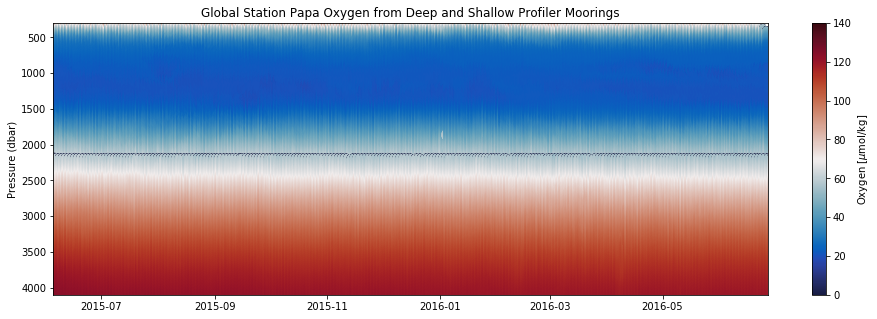

In [20]:
#Make a color plot of oxygen throughout the entire time series for the upper and lower profiler
fig,ax1 = plt.subplots(1,1,figsize=(16,5))
sc1 = ax1.scatter(dtime, pressure, c=oxygen, cmap=cmocean.cm.balance, vmin=0, vmax=140)
sc2 = ax1.scatter(dtime2, pressure2, c=oxygen2, cmap=cmocean.cm.balance, vmin=0, vmax=140)
ax1.invert_yaxis() # Invert y axis
ax1.set_xlim(dtime[0],dtime[-1]) # Set the time limits to match the dataset
ax1.set_ylim(4100,300)
cbar = fig.colorbar(sc1, ax=ax1, orientation='vertical')
cbar.ax.set_ylabel('Oxygen [$\mu$mol/kg]')
ax1.set_ylabel('Pressure (dbar)')
ax1.set_title('Global Station Papa Oxygen from Deep and Shallow Profiler Moorings')

Notice the black line around ~2200m in the plot above. It appears that, for both the upper and lower profiler, the top and bottom of the oxygen profiles have values of 0. To get rid of these, you can simply drop the values where dissolved oxygen is equal to zero. However, this workaround wouldn't be very good for oxygen profiles from areas (e.g. coastal zones or ODZs) where oxygen concentrations drop below the detection limit of the sensor. 

In [21]:
# # Extract the values, but drop the top and bottom of profiles where Oxygen=0
dtime = ds.where(ds.dissolved_oxygen>0, drop=True)['time'].values
pressure = ds.where(ds.dissolved_oxygen>0, drop=True)['int_ctd_pressure'].values
temperature = ds.where(ds.dissolved_oxygen>0, drop=True)['ctdpf_ckl_seawater_temperature'].values
salinity = ds.where(ds.dissolved_oxygen>0, drop=True)['practical_salinity'].values
oxygen = ds.where(ds.dissolved_oxygen>0, drop=True)['dissolved_oxygen'].values
dtime2 = ds2.where(ds2.dissolved_oxygen>0, drop=True)['time'].values
pressure2 = ds2.where(ds2.dissolved_oxygen>0, drop=True)['int_ctd_pressure'].values
temperature2 = ds2.where(ds2.dissolved_oxygen>0, drop=True)['ctdpf_ckl_seawater_temperature'].values
salinity2 = ds2.where(ds2.dissolved_oxygen>0, drop=True)['practical_salinity'].values
oxygen2 = ds2.where(ds2.dissolved_oxygen>0, drop=True)['dissolved_oxygen'].values

Text(0.5,1,'Global Station Papa Oxygen from Deep and Shallow Profiler Moorings')

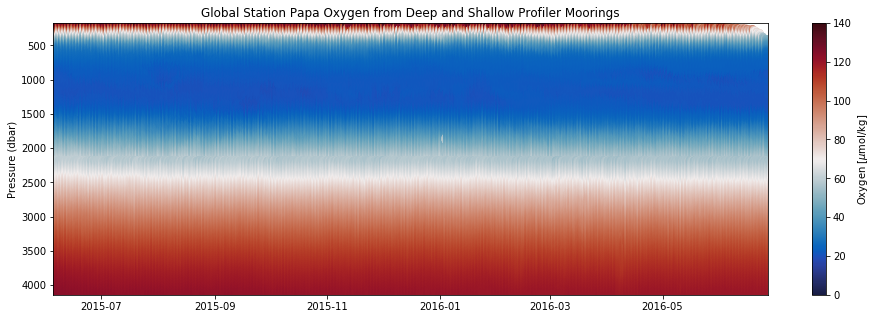

In [22]:
fig,ax1 = plt.subplots(1,1,figsize=(16,5))
sc1 = ax1.scatter(dtime, pressure, c=oxygen, cmap=cmocean.cm.balance, vmin=0, vmax=140)
sc2 = ax1.scatter(dtime2, pressure2, c=oxygen2, cmap=cmocean.cm.balance, vmin=0, vmax=140)
ax1.invert_yaxis() # Invert y axis
ax1.set_xlim(dtime[0],dtime[-1]) # Set the time limits to match the dataset
ax1.set_ylim(pressure2.max(), pressure.min()) #Set pressure limits to match dataset too
cbar = fig.colorbar(sc1, ax=ax1, orientation='vertical')
cbar.ax.set_ylabel('Oxygen [$\mu$mol/kg]')
ax1.set_ylabel('Pressure (dbar)')
ax1.set_title('Global Station Papa Oxygen from Deep and Shallow Profiler Moorings')

This is much less distracting. However, there seems to be an odd feature in the middle of the dataset. It looks like there is a transition from low oxygen to high oxygen at around ~2300dbar - suspiciously close to where the two sensors overlap. Let's zoom in on the transition

Text(0.5,1,'Global Station Papa Oxygen from Deep and Shallow Profiler Moorings')

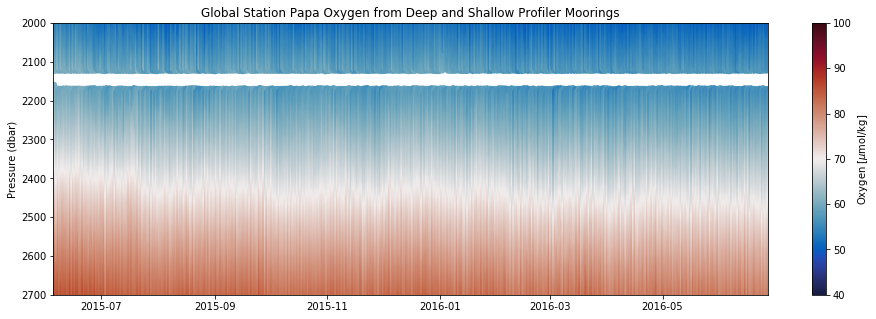

In [23]:
#Zoom in on sensor transition depths from plot above
fig,ax1 = plt.subplots(1,1,figsize=(16,5))
sc1 = ax1.scatter(dtime, pressure, c=oxygen, cmap=cmocean.cm.balance, vmin=40, vmax=100)
sc2 = ax1.scatter(dtime2, pressure2, c=oxygen2, cmap=cmocean.cm.balance, vmin=40, vmax=100)
ax1.invert_yaxis() # Invert y axis
ax1.set_xlim(dtime[0],dtime[-1]) # Set the time limits to match the dataset
ax1.set_ylim(2700,2000) #Set pressure limits to zoom in on the overlap of the two sensors
cbar = fig.colorbar(sc1, ax=ax1, orientation='vertical')
cbar.ax.set_ylabel('Oxygen [$\mu$mol/kg]')
ax1.set_ylabel('Pressure (dbar)')
ax1.set_title('Global Station Papa Oxygen from Deep and Shallow Profiler Moorings')

The sensor gap can be seen as the white band near 2150 dbar. Interestingly, the data from the two sensors seem to overlap decently (though this is not the best visualization to inspect that in detail) from ~2000-2350 dbar, before oxygen concentrations begin increasing. Perhaps this simply reflects increasing oxygen concentrations with depth below 2400m in the deep Pacific Ocean

To test this, let's inspect bottle oxygen data from a WOCE cruise to the same location in 1994. Historical WOCE bottle data can be downloaded from the [CCHDO website](https://cchdo.ucsd.edu/cruise/18DD9403_1)

In [24]:
#Load in CSV data from WOCE P15N line 
woce = pd.read_csv('18DD19940906_hy1.csv', skiprows=[0,1,2,3,4,5,6,8])
#Set display to see all columns
pd.set_option('display.max_columns', 43)
woce.head()

,EXPOCODE,SECT_ID,STNNBR,CASTNO,SAMPNO,BTLNBR,BTLNBR_FLAG_W,DATE,TIME,LATITUDE,LONGITUDE,DEPTH,CTDPRS,CTDTMP,CTDSAL,CTDSAL_FLAG_W,SALNTY,SALNTY_FLAG_W,THETA,OXYGEN,OXYGEN_FLAG_W,SILCAT,SILCAT_FLAG_W,NITRAT,NITRAT_FLAG_W,NITRIT,NITRIT_FLAG_W,PHSPHT,PHSPHT_FLAG_W,CFC-11,CFC-11_FLAG_W,CFC-12,CFC-12_FLAG_W,DELC14,DELC14_FLAG_W,DELC13,DELC13_FLAG_W,O18O16,O18O16_FLAG_W,TCARBN,TCARBN_FLAG_W,ALKALI,ALKALI_FLAG_W
0,18DD9403_1,PR06,4.0,3.0,24.0,23,2.0,19940907.0,2035.0,48.6563,-126.6468,1290.0,10.0,16.9365,31.9819,2.0,32.004,2.0,16.9349,255.6,2.0,5.4,2.0,0.1,2.0,0.00,2.0,0.30,2.0,-999.0,9.0,-999.0,9.0,-999.0,9.0,-999.0,9.0,-999.0,9.0,1928.1,2.0,2163.7,2.0
1,18DD9403_1,PR06,4.0,3.0,25.0,22,2.0,19940907.0,2035.0,48.6563,-126.6468,1290.0,50.0,9.4248,32.4710,2.0,32.465,2.0,9.4194,274.2,2.0,9.1,2.0,5.6,2.0,0.06,2.0,0.77,2.0,-999.0,9.0,-999.0,9.0,-999.0,9.0,-999.0,9.0,-999.0,9.0,2011.5,2.0,2189.3,2.0
2,18DD9403_1,PR06,4.0,3.0,26.0,21,2.0,19940907.0,2035.0,48.6563,-126.6468,1290.0,101.0,7.9099,33.1165,2.0,33.158,2.0,7.9001,201.5,2.0,23.0,2.0,20.1,2.0,0.02,2.0,1.58,2.0,-999.0,9.0,-999.0,9.0,-999.0,9.0,-999.0,9.0,-999.0,9.0,2078.8,2.0,2229.3,2.0
3,18DD9403_1,PR06,4.0,3.0,27.0,20,2.0,19940907.0,2035.0,48.6563,-126.6468,1290.0,101.0,7.9265,33.1165,2.0,33.155,2.0,7.9167,202.6,2.0,22.8,2.0,20.1,2.0,0.01,2.0,1.59,2.0,-999.0,9.0,-999.0,9.0,-999.0,9.0,-999.0,9.0,-999.0,9.0,2105.6,2.0,2220.7,2.0
4,18DD9403_1,PR06,4.0,3.0,28.0,19,2.0,19940907.0,2035.0,48.6563,-126.6468,1290.0,101.0,7.9110,33.1165,2.0,33.138,2.0,7.9012,202.0,2.0,22.6,2.0,19.9,2.0,0.01,2.0,1.57,2.0,-999.0,9.0,-999.0,9.0,-999.0,9.0,-999.0,9.0,-999.0,9.0,-999.0,9.0,2231.0,2.0


In [25]:
#Slice a subset of the profiler data to be roughly representative of the section
dss = ds.sel(time=slice('2015-09-01', '2015-09-21'))
dss2 = ds2.sel(time=slice('2015-09-01', '2015-09-21'))

Text(0.5,1,'Comparison WOCE P16N and OOI Profiler O$_{2}$ Data')

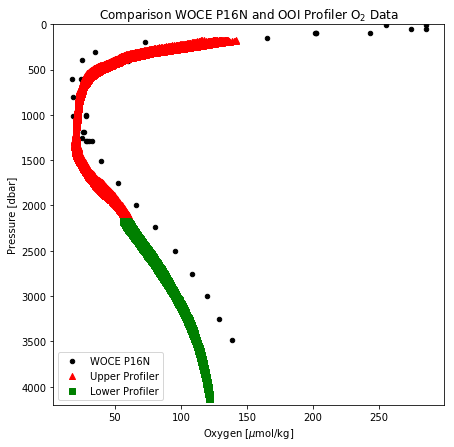

In [26]:
#Query and plot only bottle data from station 4, the furthest north station closest to Station Papa
fig,ax1 = plt.subplots(1,1,figsize=(7,7))
woce.query('STNNBR==4 & OXYGEN_FLAG_W==2').plot(kind='scatter', x='OXYGEN', y='CTDPRS', ax=ax1, 
                                                label='WOCE P16N', color='k')
ax1.scatter(dss.where(dss.dissolved_oxygen>0, drop=True).dissolved_oxygen, 
            dss.where(dss.dissolved_oxygen>0, drop=True).int_ctd_pressure, marker='^', color='red', label='Upper Profiler')
ax1.scatter(dss2.where(dss2.dissolved_oxygen>0, drop=True).dissolved_oxygen, 
            dss2.where(dss2.dissolved_oxygen>0, drop=True).int_ctd_pressure, marker='s', color='green', label='Lower Profiler')
ax1.set_ylim(4200,0)
ax1.set_ylabel('Pressure [dbar]')
ax1.set_xlabel('Oxygen [$\mu$mol/kg]')
ax1.legend()
ax1.set_title('Comparison WOCE P16N and OOI Profiler O$_{2}$ Data')


It appears that there are some discrepancies between the bottle and sensor data - but that they are not limited to the lower profiler. In fact, it looks like there may be a pressure effect on the difference between the bottle and sensor data. Above 1000m, it appears that the sensors record greater oxygen than the bottle data - but there is a transition, and below 1000m the sensors record lower oxygen than the bottle data - with the difference increasing with depth. 

We also note that there seems to be a small offset between upper and lower profiler data, but that it is minor in comparison to the larger issue of the pressure-dependent offset. 

Since I have been using the corrected data, it could be that either the algorithm for making the pressure correction isn't being properly implemented, or the pressure effect on the Anderaa 4300 optode is greater for the sensors deployed at Global Station Papa than for other previously studied sensors.

The [pressure correction](https://github.com/oceanobservatories/ion-functions/blob/master/ion_functions/data/do2_functions.py) made to OOI oxygen data is 3.2% per 1000 dbar, consistent with the findings of [Bittig et al. 2015](https://journals.ametsoc.org/doi/full/10.1175/JTECH-D-15-0108.1). 


Of course, the WOCE data is from 1994, and the sensor data is from 2015 - and only from a limited, 3 week subset of the total sensor data. It is possible that the sensors have drifted through time, or that there is decadal variability in deep oxygen in the North Pacific. We examine these potential issues below

## Testing for Instrumental Drift

To test for instrumental drift over the course of deployment, take a subset of the data from the ~first day of each month, every 2 months, over the course of the deployment, and plot it against pressure. This should also give us an initial indication of whether the data are changing through time - and perhaps even whether the change through time varies with depth

In [27]:
#Make life easier by getting rid of all the oxygen=0 data in both datasets
ds = ds.where(ds.dissolved_oxygen>0, drop=True)
ds2 = ds2.where(ds2.dissolved_oxygen>0, drop=True)

Text(0.5,1,'Upper GSP Profiler O$_{2}$ Through Time')

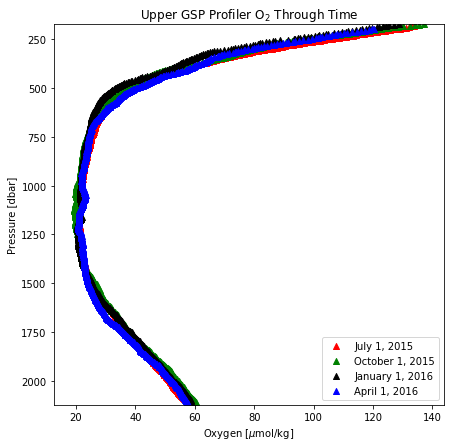

In [28]:
#Query and plot only bottle data from station 4, the furthest north station closest to Station Papa
fig = plt.figure(figsize=(7,7))
ax1 = fig.add_subplot(111)
ax1.scatter(ds.sel(time=slice('2015-07-01', '2015-07-01')).dissolved_oxygen, 
            ds.sel(time=slice('2015-07-01', '2015-07-01')).int_ctd_pressure, 
    marker='^', color='red', label='July 1, 2015')
ax1.scatter(ds.sel(time=slice('2015-10-01', '2015-10-01')).dissolved_oxygen, 
            ds.sel(time=slice('2015-10-01', '2015-10-01')).int_ctd_pressure, 
    marker='^', color='green', label='October 1, 2015')
ax1.scatter(ds.sel(time=slice('2016-01-01', '2016-01-01')).dissolved_oxygen, 
            ds.sel(time=slice('2016-01-01', '2016-01-01')).int_ctd_pressure, 
    marker='^', color='black', label='January 1, 2016')
ax1.scatter(ds.sel(time=slice('2016-04-01', '2016-04-01')).dissolved_oxygen, 
            ds.sel(time=slice('2016-04-01', '2016-04-01')).int_ctd_pressure, 
    marker='^', color='blue', label='April 1, 2016')
ax1.set_ylabel('Pressure [dbar]')
ax1.set_xlabel('Oxygen [$\mu$mol/kg]')
ax1.set_ylim(pressure.max(), pressure.min())
ax1.legend()
ax1.set_title('Upper GSP Profiler O$_{2}$ Through Time')

The upper profiler doesn't seem to have any significant drift over the course of the deployment. What about the lower profiler?

Text(0.5,1,'Lower GSP Profiler O$_{2}$ Through Time')

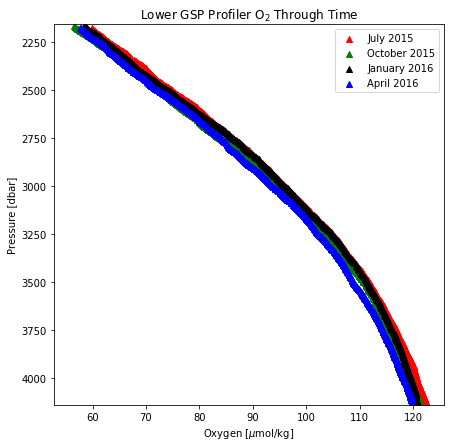

In [29]:
#Query and plot only bottle data from station 4, the furthest north station closest to Station Papa
fig = plt.figure(figsize=(7,7))
ax1 = fig.add_subplot(111)
ax1.scatter(ds2.sel(time=slice('2015-07-01', '2015-07-01')).dissolved_oxygen, 
            ds2.sel(time=slice('2015-07-01', '2015-07-01')).int_ctd_pressure, 
    marker='^', color='red', label='July 2015')
ax1.scatter(ds2.sel(time=slice('2015-10-01', '2015-10-01')).dissolved_oxygen, 
            ds2.sel(time=slice('2015-10-01', '2015-10-01')).int_ctd_pressure, 
    marker='^', color='green', label='October 2015')
ax1.scatter(ds2.sel(time=slice('2016-01-01', '2016-01-01')).dissolved_oxygen, 
            ds2.sel(time=slice('2016-01-01', '2016-01-01')).int_ctd_pressure, 
    marker='^', color='black', label='January 2016')
ax1.scatter(ds2.sel(time=slice('2016-04-21', '2016-04-21')).dissolved_oxygen, 
            ds2.sel(time=slice('2016-04-21', '2016-04-21')).int_ctd_pressure, 
    marker='^', color='blue', label='April 2016')
ax1.set_ylabel('Pressure [dbar]')
ax1.set_xlabel('Oxygen [$\mu$mol/kg]')
ax1.set_ylim(pressure2.max(), pressure2.min())
ax1.legend()
ax1.set_title('Lower GSP Profiler O$_{2}$ Through Time')

There appears to be some minor drift in the sensor deployed on the lower sensor, but in the wrong direction necessary to explain the difference between bottle and sensor data

Next I inspect whether decadal changes could be responsible for the difference - e.g. whether the WOCE data is the improper comparison for the OOI data, since the WOCE data was collected over 20 years ago. 

The [Line P Program](https://waterproperties.ca/linep/index.php) is a hydrographic time series operated by Fisheries and Oceans Canada. Their station P26 overlaps with Global Station Papa, and there is bottle oxygen data collected from P26 in August 2015 that overlaps with the sensor data from cruise 2015-10. 

In [30]:
#Load in Line P data - collected on August 28, 2015
linep = pd.read_csv('LineP_Oxygen_2015.csv')

Text(0.5,1,'O$_{2}$ from WOCE P16N, Line P, and GSP Profilers')

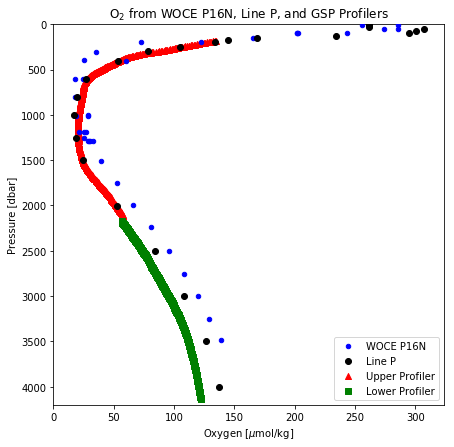

In [31]:
#Compare Line P data with Oxygen data from sensors on August 28, 2015
#Query and plot only bottle data from station 4, the furthest north station closest to Station Papa
fig,ax1 = plt.subplots(1,1,figsize=(7,7))
woce.query('STNNBR==4 & OXYGEN_FLAG_W==2').plot(kind='scatter', x='OXYGEN', y='CTDPRS', ax=ax1, 
                                                label='WOCE P16N', color='b', zorder=3)
ax1.scatter(linep.Oxygen, linep.CTDPRS, marker='o', color='black', label='Line P', zorder=4)
ax1.scatter(ds.sel(time=slice('2015-08-25', '2015-08-25')).dissolved_oxygen, 
            ds.sel(time=slice('2015-08-25', '2015-08-25')).int_ctd_pressure,
            marker='^', color='red', label='Upper Profiler')
ax1.scatter(ds2.sel(time=slice('2015-08-25', '2015-08-25')).dissolved_oxygen, 
            ds2.sel(time=slice('2015-08-25', '2015-08-25')).int_ctd_pressure, 
            marker='s', color='green', label='Lower Profiler')
ax1.set_ylim(4200,0)
ax1.set_ylabel('Pressure [dbar]')
ax1.set_xlabel('Oxygen [$\mu$mol/kg]')
ax1.legend(loc=4)
ax1.set_title('O$_{2}$ from WOCE P16N, Line P, and GSP Profilers')


Very Interesting! Now it seems as if the upper profiler lines up nicely with the bottle oxygen data from Line P, but the lower profiler is biased low compared to the bottle data. This seems to eliminate the idea that the pressure dependence of the sensors is an issue. The differences in North Pacific bottle O$_{2}$ between 1994 WOCE P16N and 2015 Line P data are difficult to explain. Studies of O$_{2}$ in the North Pacific, including repeat hydrographic data, have found decadal decreases in O$_{2}$ between the 1990s and 2000s (e.g. [Mecking et al. 2008](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/2007GB003101)). However, this data indicates that, above, ~750m, O$_{2}$ seems to have increased from 1994 to 2015. Whether this is a real change, or a potential data artifact in the 1994 data is beyond the scope of this report

Regardless, it is clear from comparison to Line P data that the lower profiler is biased low. This is also apparent when examining the crossover from the upper profiler to lower profiler at ~2100 dbar - where there is a discontinuous jump to lower oxygen. 

Recall from the annotation of the lower profiler dataset that deployment 4 O$_{2}$ data matched with historical data better than deployment 3, and that deployment 3 data was similar to deployment 1

In [32]:
df2

,annotation,id,node,sensor,site,start,stop
0,Deployment 5: No data will be available via satellite telemetry. Data will be available when the mooring is recovered.,140.0,None,None,GP02HYPM,2017-07-15 21:25:00,None
1,Deployment 2: Profiler failed due to depleted battery.,715.0,WFP03,None,GP02HYPM,2015-04-05 05:46:00,2015-06-02 00:00:00
2,"Deployment 2: Platform was deployed on 6/16/2014, recovered on 6/21/2014 at 03:28 UTC due to firmware issue and re-deployed with updated firmware on 6/22/2014 at 02:14 UTC",580.0,None,None,GP02HYPM,2014-06-21 03:28:00,2014-06-22 02:14:00
3,"There is a substantial change in dissolved oxygen measurements reported by this instrument between deployments 3 and 4. A Subject Matter Expert compared the profiler data to data from the most recent U.S. GO-SHIP occupation of P16N (2015) and suggested that data from deployment 3 are suspect (the external dataset more closely aligns with data from deployment 4). Additionally, profiler data from deployment 1 more closely resemble data from deployment 3, so those data are also suspect. We have not independently verified the analysis, investigation is pending.",1444.0,WFP03,03-DOSTAL000,GP02HYPM,2013-07-26 15:02:06,2017-07-16 06:04:17


Let's load in the deployment 1 data and do the same thing - comparing to the contemporaneous 2013 Line P O$_{2}$ data

In [33]:
#Load in Deployment 1 data
ds3 = xr.open_dataset(datasets[7])
ds4 = xr.open_dataset(datasets2[7])
# By default, OOI datasets use the 'obs' variable as the index, but time is more convenient
ds3 = ds3.swap_dims({'obs': 'time'})
ds4 = ds4.swap_dims({'obs': 'time'})
#Get rid of 0 values
ds3 = ds3.where(ds3.dissolved_oxygen>0, drop=True)
ds4 = ds4.where(ds4.dissolved_oxygen>0, drop=True)

In [34]:
#Load in 2013 Line P data - collected on August 31, 2013
linep = pd.read_csv('LineP_Oxygen_2013.csv')
#Also load in February 2014 Line P data - collected February 19, 2014
linep2 = pd.read_csv('LineP_Oxygen_feb2014.csv')
#Get rid of questionable data
linep = linep.query('Oxygen_flag==[0,2,6]')
linep2 = linep2.query('Oxygen_flag==[0,2,6]')

Text(0.5,1,'O$_{2}$ from Line P and GSP Profilers on August 31, 2013')

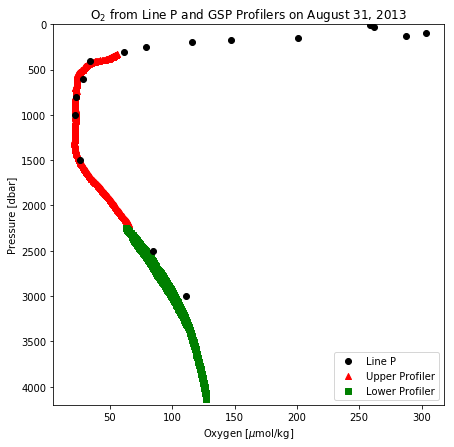

In [35]:
#Compare OOI data with 2013 Line P data
fig,ax1 = plt.subplots(1,1,figsize=(7,7))
ax1.scatter(linep.Oxygen, linep.CTDPRS, marker='o', color='black', label='Line P', zorder=4)
ax1.scatter(ds3.sel(time=slice('2013-08-31', '2013-08-31')).dissolved_oxygen, 
            ds3.sel(time=slice('2013-08-31', '2013-08-31')).int_ctd_pressure,
            marker='^', color='red', label='Upper Profiler')
ax1.scatter(ds4.sel(time=slice('2013-08-31', '2013-08-31')).dissolved_oxygen, 
            ds4.sel(time=slice('2013-08-31', '2013-08-31')).int_ctd_pressure, 
            marker='s', color='green', label='Lower Profiler')
ax1.set_ylim(4200,0)
ax1.set_ylabel('Pressure [dbar]')
ax1.set_xlabel('Oxygen [$\mu$mol/kg]')
ax1.legend(loc=4)
ax1.set_title('O$_{2}$ from Line P and GSP Profilers on August 31, 2013')

There is limited data the compare with the lower profiler, but preliminary indication of an offset, once again. 

To further inspect, we also compare with data from the February 2014 Line P Cruise.

Text(0.5,1,'O$_{2}$ from Line P and GSP Profilers on February 19, 2014')

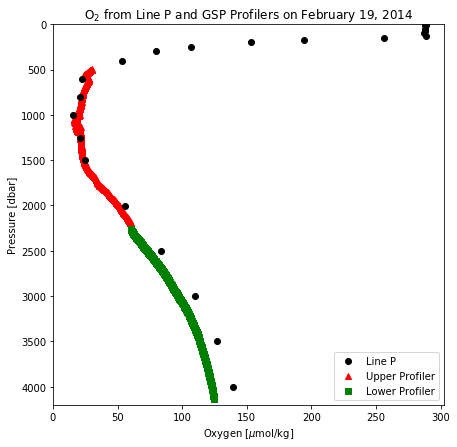

In [36]:
#Compare OOI data with 2014 Line P data
fig,ax1 = plt.subplots(1,1,figsize=(7,7))
ax1.scatter(linep2.Oxygen, linep2.CTDPRS, marker='o', color='black', label='Line P', zorder=4)
ax1.scatter(ds3.sel(time=slice('2014-02-19', '2014-02-19')).dissolved_oxygen, 
            ds3.sel(time=slice('2014-02-19', '2014-02-19')).int_ctd_pressure,
            marker='^', color='red', label='Upper Profiler')
ax1.scatter(ds4.sel(time=slice('2014-02-19', '2014-02-19')).dissolved_oxygen, 
            ds4.sel(time=slice('2014-02-19', '2014-02-19')).int_ctd_pressure, 
            marker='s', color='green', label='Lower Profiler')
ax1.set_ylim(4200,0)
ax1.set_ylabel('Pressure [dbar]')
ax1.set_xlabel('Oxygen [$\mu$mol/kg]')
ax1.legend(loc=4)
ax1.set_title('O$_{2}$ from Line P and GSP Profilers on February 19, 2014')

This makes it clear - the data from the deep profiler is offset lower than bottle data. There is a hint of the upper profiler being lower than the bottle data for the 2000 dbar sample, but it is not conclusive.

The annotation for this instrument indicated that the issue seemed to be with deployments 1 and 3 - but after seeing this, it seems logical to make the same comparisons for deployments 2 and 4 as well to see if there are systematic issues with the profiler data

In [60]:
#Load in Deployment 2 data
ds5 = xr.open_dataset(datasets[5])
ds6 = xr.open_dataset(datasets2[5])
# By default, OOI datasets use the 'obs' variable as the index, but time is more convenient
ds5 = ds5.swap_dims({'obs': 'time'})
ds6 = ds6.swap_dims({'obs': 'time'})
#Get rid of 0 values
ds5 = ds5.where(ds5.dissolved_oxygen>0, drop=True)
ds6 = ds6.where(ds6.dissolved_oxygen>0, drop=True)

In [38]:
#Also load in February 2015 Line P data - collected February 18, 2015
linep3 = pd.read_csv('LIneP_Oxygen_Feb2015.csv')
#Get rid of questionable data
linep3 = linep3.query('Oxygen_flag==[0,2,6]')

Text(0.5,1,'O$_{2}$ from Line P and GSP Profilers on February 19, 2015')

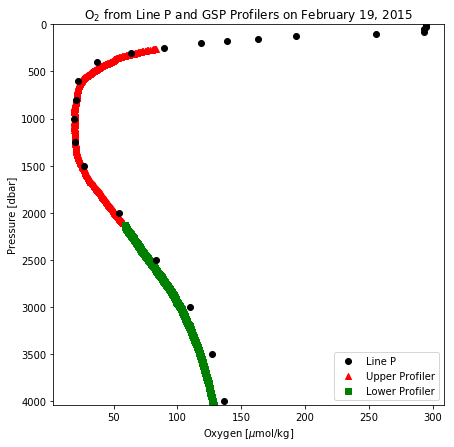

In [39]:
#Compare OOI data with 2013 Line P data
#Data from the lower profiler isn't available on the same day, so just take all the data
#There should be little short-term variability in oxygen below 2000m in the Pacific
fig,ax1 = plt.subplots(1,1,figsize=(7,7))
ax1.scatter(linep3.Oxygen, linep3.CTDPRS, marker='o', color='black', label='Line P', zorder=4)
ax1.scatter(ds5.sel(time=slice('2015-02-18', '2015-02-18')).dissolved_oxygen, 
            ds5.sel(time=slice('2015-02-18', '2015-02-18')).int_ctd_pressure,
            marker='^', color='red', label='Upper Profiler')
ax1.scatter(ds6.dissolved_oxygen, 
            ds6.int_ctd_pressure, 
            marker='s', color='green', label='Lower Profiler')
ax1.set_ylim(4038,0)
ax1.set_ylabel('Pressure [dbar]')
ax1.set_xlabel('Oxygen [$\mu$mol/kg]')
ax1.legend(loc=4)
ax1.set_title('O$_{2}$ from Line P and GSP Profilers on February 19, 2015')

The effect appears to be less than for deployments 1 and 3, but there still seems to be a depth-dependent offset between the profilers and the shipboard bottle data.

Finally, let's look at deployment number 4 to see if there are any issues there. Recall that the annotation for the deep profiler noted that deployment 4 seemed to agree with shipboard measurements more than deployment 3 did.

In [40]:
#Load in Deployment 4 data
ds7 = xr.open_dataset(datasets[1])
ds8 = xr.open_dataset(datasets2[1])
# By default, OOI datasets use the 'obs' variable as the index, but time is more convenient
ds7 = ds7.swap_dims({'obs': 'time'})
ds8 = ds8.swap_dims({'obs': 'time'})
#Get rid of 0 values
ds7 = ds7.where(ds7.dissolved_oxygen>0, drop=True)
ds8 = ds8.where(ds8.dissolved_oxygen>0, drop=True)

In [41]:
#Also load in August 2016 Line P data - collected August 26, 2016
linep4 = pd.read_csv('LineP_Oxygen_Aug2016.csv')
#Get rid of questionable data
linep4 = linep4.query('Oxygen_flag==[0,2,6]')

Text(0.5,1,'O$_{2}$ from Line P and GSP Profilers on August 26, 2016')

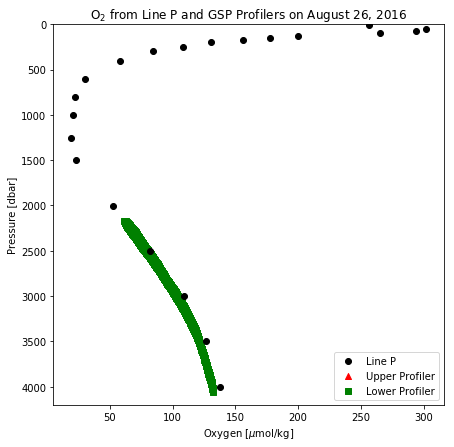

In [42]:
#Compare OOI data with 2016 Line P data
#There should be little short-term variability in oxygen below 2000m in the Pacific
fig,ax1 = plt.subplots(1,1,figsize=(7,7))
ax1.scatter(linep4.Oxygen, linep4.CTDPRS, marker='o', color='black', label='Line P', zorder=4)
ax1.scatter(ds7.sel(time=slice('2016-08-26', '2016-08-26')).dissolved_oxygen, 
            ds7.sel(time=slice('2016-08-26', '2016-08-26')).int_ctd_pressure,
            marker='^', color='red', label='Upper Profiler')
ax1.scatter(ds8.sel(time=slice('2016-08-26', '2016-08-26')).dissolved_oxygen, 
            ds8.sel(time=slice('2016-08-26', '2016-08-26')).int_ctd_pressure, 
            marker='s', color='green', label='Lower Profiler')
ax1.set_ylim(4200,0)
ax1.set_ylabel('Pressure [dbar]')
ax1.set_xlabel('Oxygen [$\mu$mol/kg]')
ax1.legend(loc=4)
ax1.set_title('O$_{2}$ from Line P and GSP Profilers on August 26, 2016')

Recall that the upper profiler failed on deployment 4 so there is no data for comparison with Line P. The lower profiler fits better with bottle data than previous deployments. 

However, note that this comparison comes from August, early in the deployment. In deployment 1 there was closer agreement between the profiler data and bottle data in August than there was the following February, and that there seemed to be sensor drift towards lower values on the deep sensor during deployment 3. 

Let's see if there is a similar trend for deployment 4 - and whether drift in the optode deployed on the deep profiler can explain some of the discrepancies we have observed between profiler data and bottle data

Text(0.5,1,'Lower GSP Profiler O$_{2}$ Through Time During Deployment 4')

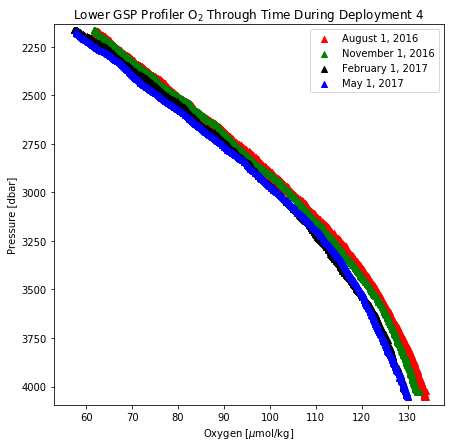

In [43]:
#Query and plot only bottle data from station 4, the furthest north station closest to Station Papa
fig = plt.figure(figsize=(7,7))
ax1 = fig.add_subplot(111)
ax1.scatter(ds8.sel(time=slice('2016-08-01', '2016-08-01')).dissolved_oxygen, 
            ds8.sel(time=slice('2016-08-01', '2016-08-01')).int_ctd_pressure, 
    marker='^', color='red', label='August 1, 2016')
ax1.scatter(ds8.sel(time=slice('2016-11-01', '2016-11-01')).dissolved_oxygen, 
            ds8.sel(time=slice('2016-11-01', '2016-11-01')).int_ctd_pressure, 
    marker='^', color='green', label='November 1, 2016')
ax1.scatter(ds8.sel(time=slice('2017-02-01', '2017-02-01')).dissolved_oxygen, 
            ds8.sel(time=slice('2017-02-01', '2017-02-01')).int_ctd_pressure, 
    marker='^', color='black', label='February 1, 2017')
ax1.scatter(ds8.sel(time=slice('2017-05-01', '2017-05-01')).dissolved_oxygen, 
            ds8.sel(time=slice('2017-05-01', '2017-05-01')).int_ctd_pressure, 
    marker='^', color='blue', label='May 1, 2017')
ax1.set_ylabel('Pressure [dbar]')
ax1.set_xlabel('Oxygen [$\mu$mol/kg]')
ax1.set_ylim(ds8.int_ctd_pressure.max()+30, ds8.int_ctd_pressure.min()-30)
ax1.legend()
ax1.set_title('Lower GSP Profiler O$_{2}$ Through Time During Deployment 4')

Like we saw before, there appears to be drift in the oxygen sensors towards lower values over time. There is a hint that this effect is pressure sensitive (e.g. it didn't happen for shallow profilers), but more research is needed to determine if this is the case. As a result, there are systematic offsets between oxygen data from the lower profiler and contemporaneous hydrographic oxygen measurements. 

Finally, let's inspect the full datasets from each deployment for the lower profiler to see if there are consistent deployment to deployment offsets

In [61]:
#Get rid of weird data at the bottom of deployment 3
ds6 = ds6.where(ds6.int_ctd_pressure<4100, drop=True)

Text(0.5,1,'Lower GSP Profiler O$_{2}$ On August 1 Across Deployments')

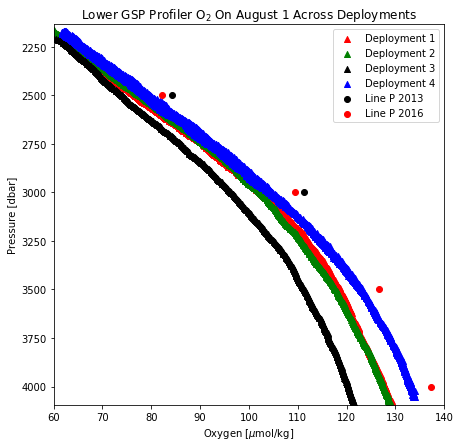

In [75]:
#Inspect offsets between deployments
fig = plt.figure(figsize=(7,7))
ax1 = fig.add_subplot(111)
ax1.scatter(ds4.sel(time=slice('2013-08-01', '2013-08-01')).dissolved_oxygen, 
            ds4.sel(time=slice('2013-08-01', '2013-08-01')).int_ctd_pressure, 
    marker='^', color='red', label='Deployment 1')
ax1.scatter(ds6.sel(time=slice('2014-06-01', '2015-06-01')).dissolved_oxygen, 
            ds6.sel(time=slice('2014-06-01', '2015-06-01')).int_ctd_pressure, 
    marker='^', color='green', label='Deployment 2')
ax1.scatter(ds2.sel(time=slice('2015-08-01', '2015-08-01')).dissolved_oxygen, 
            ds2.sel(time=slice('2015-08-01', '2015-08-01')).int_ctd_pressure, 
    marker='^', color='black', label='Deployment 3')
ax1.scatter(ds8.sel(time=slice('2016-08-01', '2016-08-01')).dissolved_oxygen, 
            ds8.sel(time=slice('2016-08-01', '2016-08-01')).int_ctd_pressure, 
    marker='^', color='blue', label='Deployment 4')
ax1.scatter(linep.Oxygen, linep.CTDPRS, marker='o', color='black', label='Line P 2013', zorder=4)
ax1.scatter(linep4.Oxygen, linep4.CTDPRS, marker='o', color='red', label='Line P 2016', zorder=4)
ax1.set_ylabel('Pressure [dbar]')
ax1.set_xlabel('Oxygen [$\mu$mol/kg]')
ax1.set_ylim(ds8.int_ctd_pressure.max()+30, ds8.int_ctd_pressure.min()-30)
ax1.set_xlim(60, 140)
ax1.legend()
ax1.set_title('Lower GSP Profiler O$_{2}$ On August 1 Across Deployments')

The deployments clearly have much different (10-15 $\mu$mol/kg) O$_{2}$ values on the deep mooring - and the differences become much greater with increasing pressure. For comparison, the variability in bottle oxygen measurements on Line P between 2013 and 2016 is much lower. This gives us more confidence that it is a sensor issue rather than interannual variability in deepwater oxygen content.

As a last check on drift, we will repeat the above plot, but for April - near the end of the deployments, to see if the drift is similar on each deployment, and whether the offsets from deployment to deployment are maintained.

Text(0.5,1,'Lower GSP Profiler O$_{2}$ On April 1 Across Deployments')

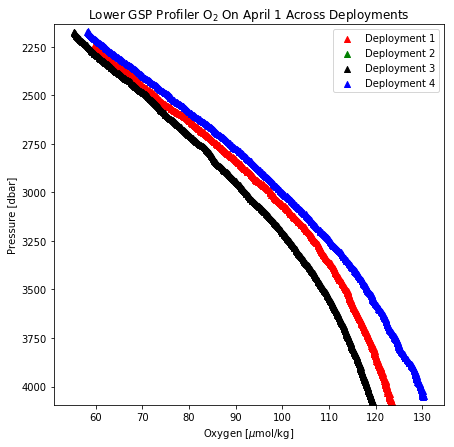

In [69]:
fig = plt.figure(figsize=(7,7))
ax1 = fig.add_subplot(111)
ax1.scatter(ds4.sel(time=slice('2014-04-01', '2014-04-01')).dissolved_oxygen, 
            ds4.sel(time=slice('2014-04-01', '2014-04-01')).int_ctd_pressure, 
    marker='^', color='red', label='Deployment 1')
ax1.scatter(ds6.sel(time=slice('2015-04-01', '2015-04-01')).dissolved_oxygen, 
            ds6.sel(time=slice('2015-04-01', '2015-04-01')).int_ctd_pressure, 
    marker='^', color='green', label='Deployment 2')
ax1.scatter(ds2.sel(time=slice('2016-04-01', '2016-04-01')).dissolved_oxygen, 
            ds2.sel(time=slice('2016-04-01', '2016-04-01')).int_ctd_pressure, 
    marker='^', color='black', label='Deployment 3')
ax1.scatter(ds8.sel(time=slice('2017-04-01', '2017-04-01')).dissolved_oxygen, 
            ds8.sel(time=slice('2017-04-01', '2017-04-01')).int_ctd_pressure, 
    marker='^', color='blue', label='Deployment 4')
ax1.set_ylabel('Pressure [dbar]')
ax1.set_xlabel('Oxygen [$\mu$mol/kg]')
ax1.set_ylim(ds8.int_ctd_pressure.max()+30, ds8.int_ctd_pressure.min()-30)
ax1.legend()
ax1.set_title('Lower GSP Profiler O$_{2}$ On April 1 Across Deployments')

There does seem to be some variable drift across deployments. The sensor on deployments 1 and 4 decreased in value much more than the sensor on deployment 3. 

## 4. Conclusions and Suggestions for Future Work

In this report I analyzed the data quality of dissolved oxygen sensors deployed on Apex profiler moorings at Global Station Papa. By comparing the data internally and with co-located shipboard oxygen measurements made by Winkler titration, we find the following:

* Values from the top and bottom of each deployment are 0 - which are not real data, and should be scrubbed from the datasets
* There are offsets from deployment to deployment in dissolved oxygen on the vertical profilers. This effect seems to be the most drastic for the oxygen sensors on the deep profiler, though some of the deeper data from the shallow profiler has issues as well. 
    * In particular, data from the deep profiler on deployments 1 and 3 are ~10 $\mu$mol/kg lower than on deployments 2 and 4.
* The vertical profilers are systematically biased towards low O$_{2}$ values compared to shipboard measurements. 
* The effect of the offsets from bottle data are exacerbated later in the deployment of the profilers. Comparing the dissolved oxygen profilers over the course of deployments, it is apparent that the oxygen sensors drift towards lower values through time.
    * Evaluating the linearity and magnitude of the drift rate was beyond the scope of this report. Future work should re-grid the data into pressure or depth bins (perhaps 1 dbar or 1m), resample daily, weekly, or monthly means, and determine how the measured oxygen values at a given depth change through time. 
        * There was a hint that the drift was pressure-dependent - e.g. that the difference between O$_{2}$ at the beginning of the deployment and the end of the deployment increased with depth. It also appeared that the offset between profiler data and bottle data increased with depth. This hypothesis should be evaluated using the methods listed above as well. 
        * It was also clear the the offsets from deployment to deployment were greater with increasing depth
* Oxygen data from the Apex profiling sensors at Station Papa should to be re-calibrated with respect to contemporaneous Line P hydrographic data, as well as corrected for drift through time, before scientific use. 
    * Similar analysis should be performed for oxygen sensors on Apex profilers at other global arrays. 